<h1 style="color: orange;
    text-align: center;
    font-weight: bold;
    font-size: 35px;">电商页面 A/B 测试分析
</h1>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">一、项目背景</h2>

<h3 style="color: purple;
    font-size: 24px;
">1、背景描述</h3>

<p style="   color: black;
    font-size: 16px;
">本项目基于项目AB实验中的一次统计学检验 ，致力于根据具体的数据集，对数据进行分析及可视化，并完整地梳理AB实验的详细过程，编程实现AB测试。最终分析新页面上线是否对用户转化带来正面影响，并基于数据反馈给出相关业务建议。</p>

<h3 style="color: purple;
    font-size: 24px;
">2、数据说明</h3>

<p style="   color: black;
    font-size: 16px;
">本次分析的数据集来源于一家电商网站。希望通过对于一次AB测试数据的分析判断新旧两版页面在用户转化上是否有显著区别，帮助公司决定是应当采用新的页面，还是保留老的页面。


首先我们要对数据进行检查和清洗，确保数据的准确性。
然后我们需要明确分析的问题，建立零假设和备选假设，判断样本的抽样分布类型和检测方式，最后根据得到的P值，判断实验性的显著性水平，得出结论。</p>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">二、数据处理</h2>

In [1]:
#导入模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

<h3 style="color: purple;
    font-size: 24px;
">1、查看、合并数据</h3>

In [36]:
data=pd.read_csv(r"E:\文件下载\web新旧页面的A_B测试\ab_data.csv")

In [37]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<h3 style="color: purple;
    font-size: 24px;
">2、清洗数据</h3>

In [39]:
#检查缺失值
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [40]:
#查询是否存在group与landing_page不符情况
t_old_error = len(data[(data['group'] == 'treatment') & (data['landing_page'] == 'old_page')])
c_new_error = len(data[(data['group'] == 'control') & (data['landing_page'] == 'new_page')])
print(
    '实验组看到老页面的人数:{}, 对照组看到新页面的人数:{}'.format(
        t_old_error,
        c_new_error))

实验组看到老页面的人数:1965, 对照组看到新页面的人数:1928


In [41]:
#正常数据量
data=data[((data['group']=='treatment')&(data['landing_page']=='new_page'))
|((data['group']=='control')&(data['landing_page']=='old_page'))]
print('正常数据',len(data))

正常数据 290585


In [42]:
#检查重复值
data.drop_duplicates(subset='user_id').head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [43]:
#删除重复值
data.drop_duplicates(subset=['user_id'],inplace=True,keep="first")

In [44]:
#重置索引
data=data.reset_index()

In [45]:
#查看数据
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         290584 non-null  int64 
 1   user_id       290584 non-null  int64 
 2   timestamp     290584 non-null  object
 3   group         290584 non-null  object
 4   landing_page  290584 non-null  object
 5   converted     290584 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.3+ MB


<h3 style="color: purple;
    font-size: 24px;
">3、提取表格有效信息</h3>

In [46]:
#流量分配比例：看到新页面的用户占比多少
zb=data[data.landing_page=='new_page'].shape[0]/data.shape[0]
print('看到新页面的用户占比：%.2f%%'%(zb*100))

看到新页面的用户占比：50.01%


<p style="   color: black;
    font-size: 16px;
">看到新页面和老页面的用户各占50%左右，流量分配相对均衡
</p>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">三、AB Test</h2>

<h3 style="color: purple;
    font-size: 24px;
">1、提出假设</h3>

<p style="   color: black;
    font-size: 16px;
">【提出零假设和备选假设】

记旧页面的转化率为 p1，新页面的转化率为 p2

零假设 ： p1>p2 即p1-p2>0
备择假设 ：p1<p2 即 p1-p2<0</p>

<h3 style="color: purple;
    font-size: 24px;
">2、确定实验对象</h3>

<p style="   color: black;
    font-size: 16px;
">本次实验满足的判断结果只有0和1（转化和未转化），符合0-1分布

0-1分布：就是n=1情况下的二项分布，任何只有两种结果的随机现象都服从0-1分布</p>

<h3 style="color: purple;
    font-size: 24px;
">3、确定实验条件</h3>

<p style="   color: black;
    font-size: 16px;
">【确定检验类型】

独立双样本，样本n>30，总体的均值和标准差未知，用Z检验。

其中，pc为转化率的联合估计</p>

<p style="   color: black;
    font-size: 16px;
">【确定检验方向】

判断是否相等就是双侧,是否大于或小于就是单测

根据备择假设，确定检验方向为单侧（左尾）</p>

<p style="   color: black;
    font-size: 16px;
">【给定显著性水平α】
本次检验α取0.05。

显著水平α：时在进行假设检验时先确定的一个可允许的作为判断界限的小概率标准（用于和P值比较大小而最终确定结论，一般常用值：0.05，0.01）</p>

<h3 style="color: purple;
    font-size: 24px;
">4、实验过程</h3>

<h4 style="color: black;
    font-size: 21px;
">独立双样本Z检验</h4>


<p style="   color: black;
    font-size: 16px;
">
Z=（p1-p2）/sqrt[p1×(1-p1)/n1+p2×(1-p2)/n2]</p>

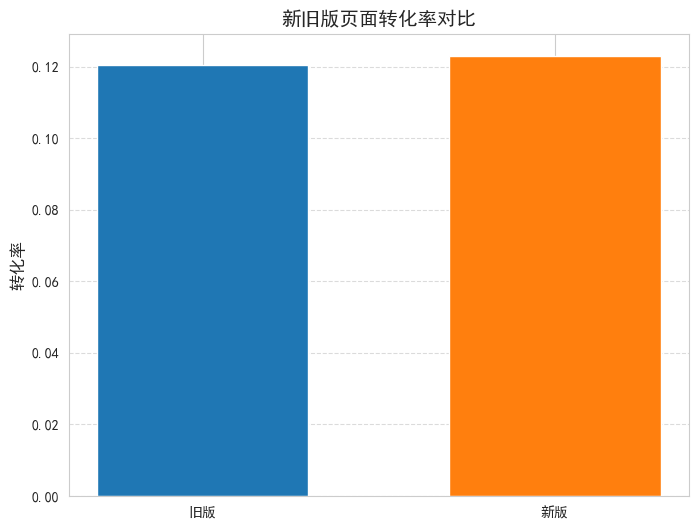

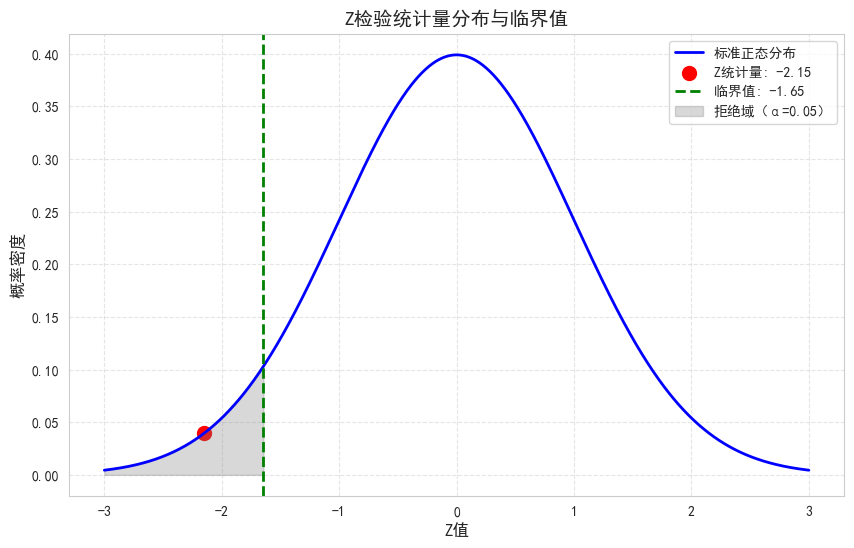

旧版总受试用户数: 145274 旧版转化用户数: 17489 旧版转化率: 0.1203863045004612
新版总受试用户数: 145310 新版转化用户数: 17872 新版转化率: 0.12299222352212512
转化率的联合估计: 0.12168942543292129
检验统计量z: -2.1484056695589
临界值z_alpha: -1.645
假设检验结果: 落入拒绝域，拒绝零假设


In [47]:
# 1. 基础指标计算
n_old = data.query('group=="control"').shape[0]
n_new = data.query('group=="treatment"').shape[0]
convert_old = data.query('group=="control" & converted==1').shape[0]
convert_new = data.query('group=="treatment" & converted==1').shape[0]
p_old = convert_old / n_old
p_new = convert_new / n_new
p_c = (convert_old + convert_new) / (n_old + n_new)
z = (p_old - p_new) / np.sqrt(p_c * (1 - p_c) * (1 / n_old + 1 / n_new))

# 2. 手动计算临界值（替代 norm.ppf）
# 单侧检验（α=0.05）的临界值（标准正态分布下约为 -1.645）
z_alpha = -1.645

# 3. 纯 matplotlib 可视化
# 3.1 转化率对比柱状图
plt.figure(figsize=(8, 6))
plt.bar(['旧版', '新版'], [p_old, p_new], color=['#1f77b4', '#ff7f0e'], width=0.6)
plt.ylabel('转化率', fontsize=12)
plt.title('新旧版页面转化率对比', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3.2 标准正态分布曲线与 Z 统计量可视化
plt.figure(figsize=(10, 6))
x = np.linspace(-3, 3, 1000)
# 手动计算标准正态分布的概率密度函数
pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, 'b-', linewidth=2, label='标准正态分布')

# 标记 Z 统计量和临界值
plt.scatter(z, (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2),
            color='r', s=100, label=f'Z统计量: {z:.2f}')
plt.axvline(z_alpha, color='g', linestyle='--', linewidth=2,
            label=f'临界值: {z_alpha:.2f}')

# 填充拒绝域（左侧阴影）
x_shade = np.linspace(-3, z_alpha, 100)
y_shade = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_shade**2)
plt.fill_between(x_shade, y_shade, color='gray', alpha=0.3,
                 label='拒绝域（α=0.05）')

plt.xlabel('Z值', fontsize=12)
plt.ylabel('概率密度', fontsize=12)
plt.title('Z检验统计量分布与临界值', fontsize=14)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# 4. 结果输出
print('旧版总受试用户数:', n_old, '旧版转化用户数:', convert_old, '旧版转化率:', p_old)
print('新版总受试用户数:', n_new, '新版转化用户数:', convert_new, '新版转化率:', p_new)
print('转化率的联合估计:', p_c)
print('检验统计量z:', z)
print('临界值z_alpha:', z_alpha)
result = "落入拒绝域，拒绝零假设" if abs(z) > abs(z_alpha) else "接受零假设"
print('假设检验结果:', result)

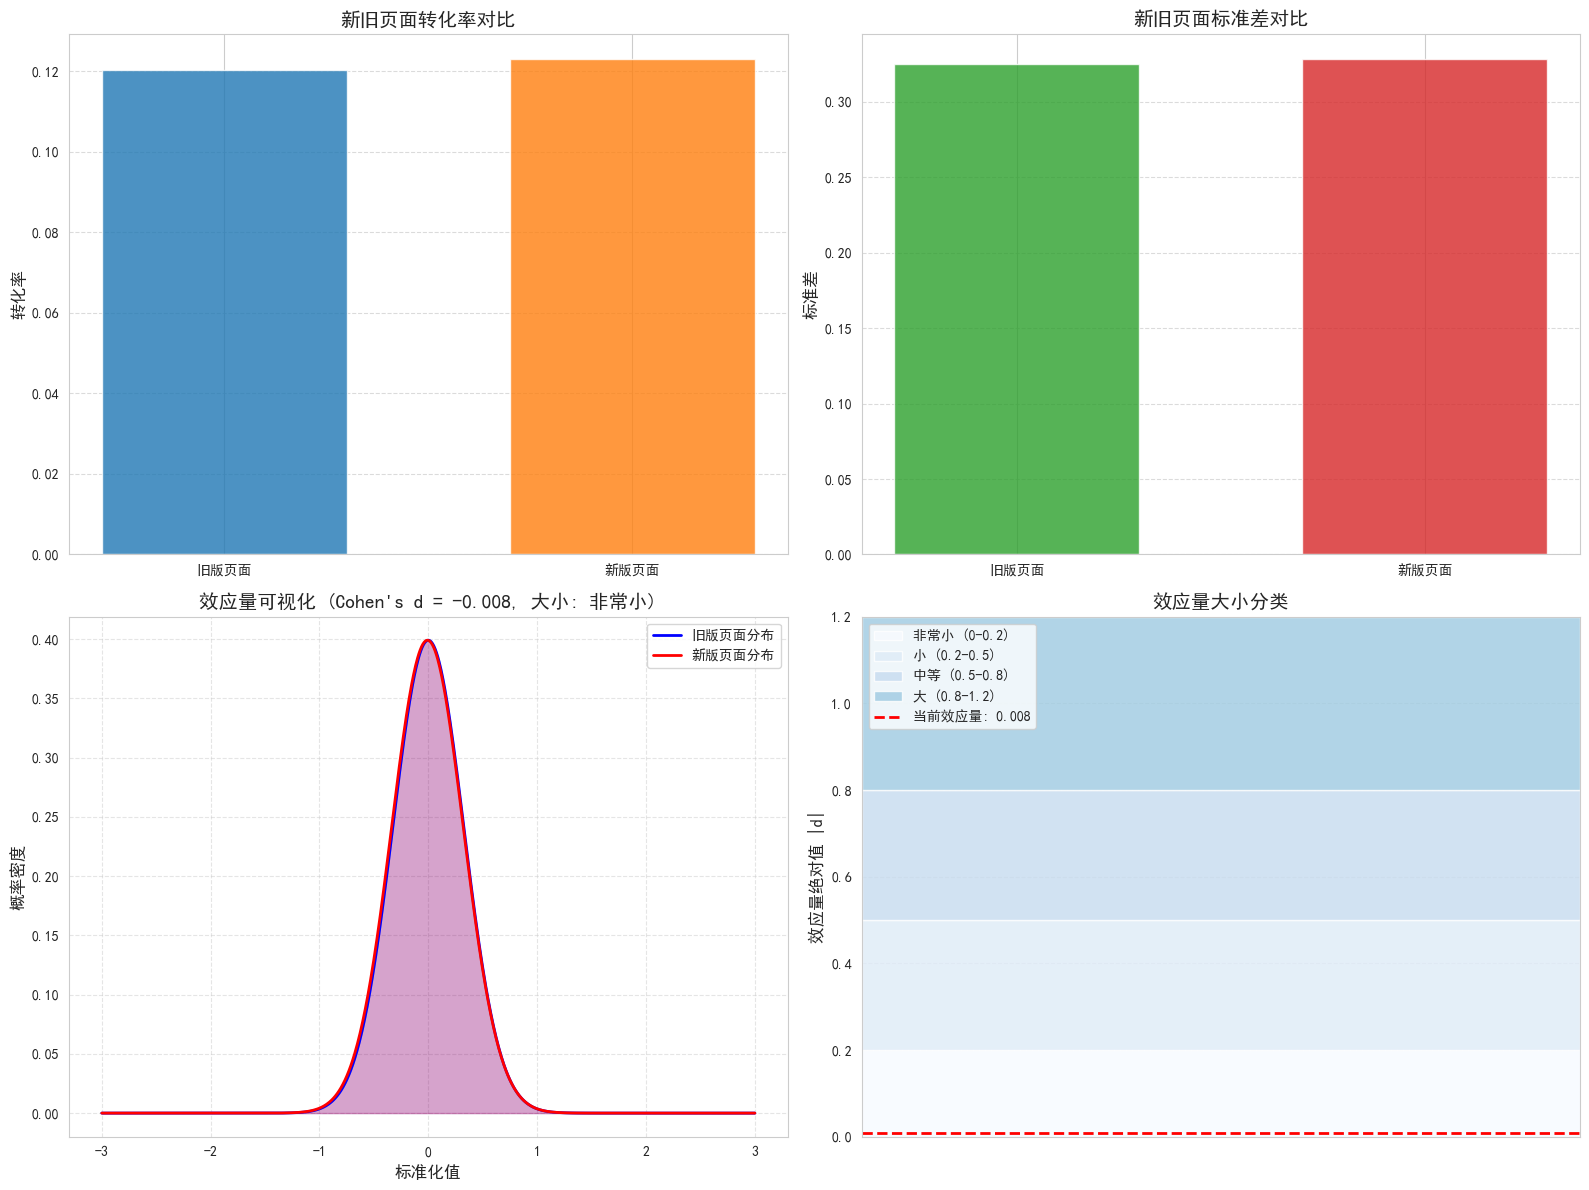

样本量:
旧版页面: 145274 用户, 新版页面: 145310 用户

转化率:
旧版页面: 0.1204, 新版页面: 0.1230

标准差:
旧版页面: 0.3254, 新版页面: 0.3284

合并标准差:
s = 0.3269

效应量 (Cohen's d):
d = -0.0080 (方向: 新版更好, 大小: 非常小)


In [48]:
# 计算标准差
std_old = data[data.landing_page == "old_page"].converted.std()
std_new = data[data.landing_page == "new_page"].converted.std()

# 合并标准差
s = np.sqrt(((n_old - 1) * std_old**2 + (n_new - 1) * std_new**2) / (n_old + n_new - 2))

# 计算Cohen's d效应量
d = (p_old - p_new) / s

# 效应量大小判断（Cohen标准）
effect_size = "非常小" if abs(d) < 0.2 else \
              "小" if abs(d) < 0.5 else \
              "中等" if abs(d) < 0.8 else \
              "大"

# 可视化部分（纯matplotlib实现）
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 转化率对比柱状图
axes[0, 0].bar(['旧版页面', '新版页面'], [p_old, p_new],
               color=['#1f77b4', '#ff7f0e'], width=0.6, alpha=0.8)
axes[0, 0].set_ylabel('转化率', fontsize=12)
axes[0, 0].set_title('新旧页面转化率对比', fontsize=14)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. 标准差对比柱状图
axes[0, 1].bar(['旧版页面', '新版页面'], [std_old, std_new],
               color=['#2ca02c', '#d62728'], width=0.6, alpha=0.8)
axes[0, 1].set_ylabel('标准差', fontsize=12)
axes[0, 1].set_title('新旧页面标准差对比', fontsize=14)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. 效应量可视化 - 分布曲线对比
x = np.linspace(-3, 3, 1000)
y_old = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / std_old)**2)
y_new = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - d) / std_new)**2)

axes[1, 0].plot(x, y_old, 'b-', linewidth=2, label='旧版页面分布')
axes[1, 0].plot(x, y_new, 'r-', linewidth=2, label='新版页面分布')
axes[1, 0].fill_between(x, y_old, color='blue', alpha=0.2)
axes[1, 0].fill_between(x, y_new, color='red', alpha=0.2)
axes[1, 0].set_xlabel('标准化值', fontsize=12)
axes[1, 0].set_ylabel('概率密度', fontsize=12)
axes[1, 0].set_title(f'效应量可视化 (Cohen\'s d = {d:.3f}, 大小: {effect_size})', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(linestyle='--', alpha=0.5)

# 4. 效应量大小分类示意图
effect_sizes = [0, 0.2, 0.5, 0.8, 1.2]
labels = ["非常小", "小", "中等", "大", "非常大"]
colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6']

for i in range(len(effect_sizes)-1):
    axes[1, 1].axhspan(effect_sizes[i], effect_sizes[i+1],
                       facecolor=colors[i], alpha=0.8,
                       label=f'{labels[i]} ({effect_sizes[i]}-{effect_sizes[i+1]})')

# 标记当前效应量位置
axes[1, 1].axhline(y=abs(d), color='red', linestyle='--', linewidth=2,
                  label=f'当前效应量: {abs(d):.3f}')

axes[1, 1].set_ylim(0, 1.2)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylabel('效应量绝对值 |d|', fontsize=12)
axes[1, 1].set_title('效应量大小分类', fontsize=14)
axes[1, 1].legend(fontsize=10, loc='upper left')
axes[1, 1].grid(linestyle='--', alpha=0.5)
axes[1, 1].set_xticks([])

plt.tight_layout()
plt.show()

# 打印计算结果
print('样本量:')
print(f'旧版页面: {n_old} 用户, 新版页面: {n_new} 用户')
print('\n转化率:')
print(f'旧版页面: {p_old:.4f}, 新版页面: {p_new:.4f}')
print('\n标准差:')
print(f'旧版页面: {std_old:.4f}, 新版页面: {std_new:.4f}')
print('\n合并标准差:')
print(f's = {s:.4f}')
print('\n效应量 (Cohen\'s d):')
print(f'd = {d:.4f} (方向: {"新版更好" if d < 0 else "旧版更好"}, 大小: {effect_size})')


<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">四、总结</h2>

<p style="   color: black;
    font-size: 16px;
">
Cohen's d的值约为-0.0080，绝对值很小。两者虽有显著性水平5%时统计意义上的显著差异，但差异的效应量很小。可以理解为显著有差异，但差异的大小不显著。</p>